In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
# Add your custom dataset class here
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
from typing import List, Optional, Sequence, Union, Any, Callable
from pathlib import Path

class ChestXRay(Dataset):
    def __init__(self, 
                 data_path: str, 
                 split: str,
                 transform: Callable,
                **kwargs):
        self.data_dir = [Path(data_path) / "chest_xray" / split / "PNEUMONIA", Path(data_path) / "chest_xray" / split / "NORMAL"]
        print(">>> self.data_dir", self.data_dir)
        self.transforms = transform
        self.imgs = sorted([f for d in self.data_dir for f in d.iterdir() if f.suffix == '.jpeg'])
        print(">>> len(self.imgs)", len(self.imgs))
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = default_loader(self.imgs[idx])
        
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, 0.0

>>> self.data_dir [PosixPath('/datasets/home/94/194/usingla/hw3ece285/chest_xray/train/PNEUMONIA'), PosixPath('/datasets/home/94/194/usingla/hw3ece285/chest_xray/train/NORMAL')]
>>> len(self.imgs) 5216


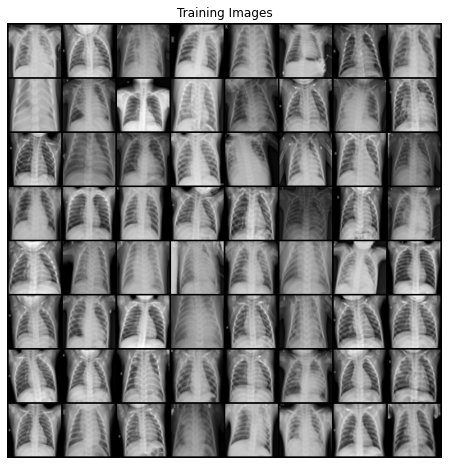

In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset

data_dir = '/datasets/home/94/194/usingla/hw3ece285/'
transform = transforms.Compose([
#             transforms.RandomHorizontalFlip(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),])
dataset = ChestXRay(
            data_dir,
            split='train',
            transform=transform,
            download=False,
        )

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/41]	Loss_D: 1.2628	Loss_G: 4.6695	D(x): 0.6418	D(G(z)): 0.4742 / 0.0145
[1/50][0/41]	Loss_D: 0.9169	Loss_G: 34.0218	D(x): 0.9996	D(G(z)): 0.5359 / 0.0000
[2/50][0/41]	Loss_D: 0.0000	Loss_G: 39.9231	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/50][0/41]	Loss_D: 0.0000	Loss_G: 39.7976	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/50][0/41]	Loss_D: 0.0000	Loss_G: 39.8575	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/50][0/41]	Loss_D: 0.0000	Loss_G: 39.8444	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[6/50][0/41]	Loss_D: 0.0000	Loss_G: 39.7314	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[7/50][0/41]	Loss_D: 0.0000	Loss_G: 39.6231	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[8/50][0/41]	Loss_D: 0.0000	Loss_G: 39.5579	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[9/50][0/41]	Loss_D: 0.0000	Loss_G: 39.3338	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[10/50][0/41]	Loss_D: 0.0000	Loss_G: 39.2485	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[11/50][0/41]	Loss_D: 0.0000	Loss_G: 39.1035	D(x): 1.0000	D(G(z)): 0.000

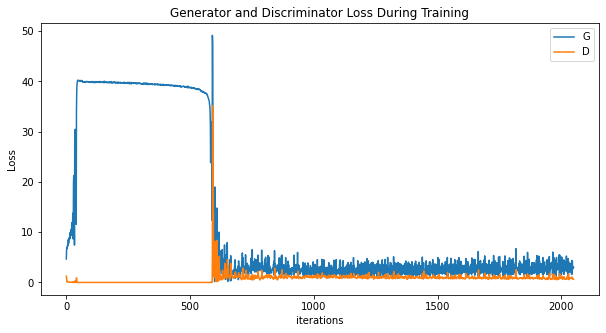

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

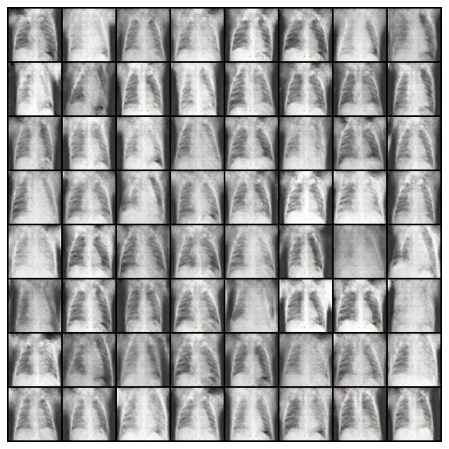

In [16]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# HTML(ani.to_jshtml())

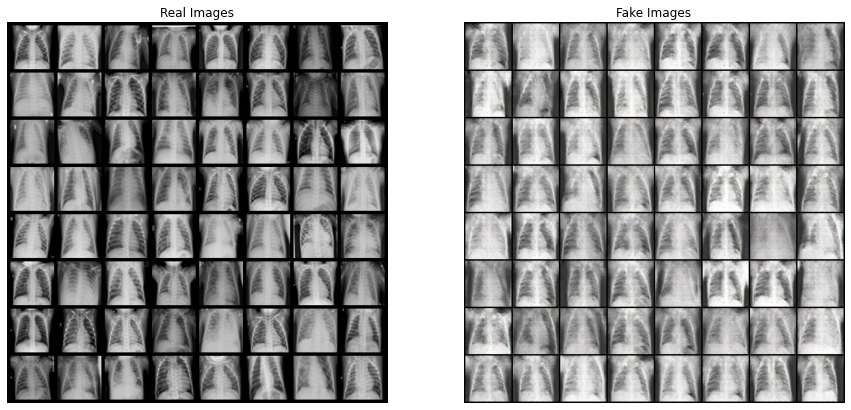

In [14]:
# Real Images vs. Fake Images
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [31]:
img_list[-1].shape

torch.Size([3, 530, 530])

In [54]:
name = 1
vutils.save_image(real_batch[0][:64] , f'/home/usingla/hw4ece285/generated/real/{name}.png' ,
                      normalize=True,
                      nrow=8)

In [65]:
name = 5
vutils.save_image(img_list[name], f'/home/usingla/hw4ece285/generated/fake/{name}.png' ,
                      normalize=True,
                      nrow=1)

In [63]:
import torch
from torch.autograd import Variable
from torchmetrics.image import FID
from torchvision.datasets.folder import default_loader
from typing import List, Optional, Sequence, Union, Any, Callable
from pathlib import Path
import sys
import torchvision.transforms as transforms


class ChestXRayProcessed(torch.utils.data.Dataset):
    def __init__(self, 
            data_dir: str, transform: Callable):

        self.data_dir = data_dir
        print(">>> self.data_dir", self.data_dir)
        self.transforms = transform
        self.suffix = '.png'
        self.imgs = sorted([f for f in self.data_dir.iterdir() if f.suffix == self.suffix])
        print(">>> len(self.imgs)", len(self.imgs))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = default_loader(self.imgs[idx])
        if self.transforms is not None:
            img = self.transforms(img)
        return img


# if __name__ == '__main__':

# version = sys.argv[1]
# print("Calculating FID on version", version)

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.uint8),
])

xray_real_dataset = ChestXRayProcessed(
        Path (f'/home/usingla/hw4ece285/generated/real'),
        transform=transforms,
    )

dataloader = torch.utils.data.DataLoader(xray_real_dataset, batch_size=len(xray_real_dataset)) # WARNING: TODO: it should be test dataset images, not real
imgs_dist1 = None
for i, batch in enumerate(dataloader, 0):
    print(i, batch.shape)
    imgs_dist1 = batch
    break

xray_fake_dataset = ChestXRayProcessed(
        Path (f'/home/usingla/hw4ece285/generated/fake/'),
        transform=transforms,
    )
dataloader = torch.utils.data.DataLoader(xray_fake_dataset, batch_size=len(xray_fake_dataset))
imgs_dist2 = None
for i, batch in enumerate(dataloader, 0):
    print(i, batch.shape)
    imgs_dist2 = batch
    break

fid = FID(feature=64)
fid.update(imgs_dist1, real=True)
fid.update(imgs_dist2, real=False)

fid_val = fid.compute()

print(fid_val)
# tensor (12.7202)


>>> self.data_dir /home/usingla/hw4ece285/generated/real
>>> len(self.imgs) 2
0 torch.Size([2, 3, 530, 530])
>>> self.data_dir /home/usingla/hw4ece285/generated/fake
>>> len(self.imgs) 1
0 torch.Size([1, 3, 530, 530])
tensor(7.0850)


In [76]:
fake_img_list = []
for name in range(64):
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)
    fake = netG(fixed_noise).detach().cpu()
    fake_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

for name in range(64):
    vutils.save_image(fake_img_list[name], f'/home/usingla/hw4ece285/generated/fake_is/{name}.png' ,
                          normalize=True,
                          nrow=1)

In [77]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3
from torchvision.datasets.folder import default_loader

import numpy as np
import sys
from scipy.stats import entropy
from typing import List, Optional, Sequence, Union, Any, Callable
from pathlib import Path

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)
    print("N", N, "batch_size", batch_size)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

if __name__ == '__main__':
#     class IgnoreLabelDataset(torch.utils.data.Dataset):
#         def __init__(self, orig):
#             self.orig = orig

#         def __getitem__(self, index):
#             return self.orig[index][0]

#         def __len__(self):
#             return len(self.orig)

    class ChestXRay(torch.utils.data.Dataset):
        def __init__(self, 
                     data_dir: str, 
                     transform: Callable):
            
            self.data_dir = data_dir
            print(">>> self.data_dir", self.data_dir)
            self.transforms = transform
            self.imgs = sorted([f for f in self.data_dir.iterdir() if f.suffix == '.png'])
            print(">>> len(self.imgs)", len(self.imgs))

        def __len__(self):
            return len(self.imgs)

        def __getitem__(self, idx):
            img = default_loader(self.imgs[idx])
            if self.transforms is not None:
                img = self.transforms(img)
            return img

    import torchvision.datasets as dset
    import torchvision.transforms as transforms
    
    version = sys.argv[1]
    print("Calculating IS on version", version)

    transforms = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),])

    xray_dataset = ChestXRay(
            Path (f'/home/usingla/hw4ece285/generated/fake_is'),
            transform=transforms,
        )

    print ("Calculating Inception Score...")
    print (inception_score(xray_dataset, cuda=True, batch_size=32, resize=True, splits=3))


Calculating IS on version -f
>>> self.data_dir /home/usingla/hw4ece285/generated/fake_is
>>> len(self.imgs) 65
Calculating Inception Score...
N 65 batch_size 32


/tmp/ipykernel_7712/1760384632.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


(1.142886163237547, 0.01263431630712601)
